# ISSS621 - Data Science for Business
# Project

## Making Recommendations of H&M products based on  Content Based Filtering

### Pseudocode: 

1. Filter the data for the last month transactions.
2. Merge the articles data with the transactions to understand the customer preference for every product purchase.
3. Select the attributes from the articles dataset that will be used to measure preferences of the customer.
4. Filter the transactions with the users who purchase a minimum of 2 articles to remove noise/one time buyers.
5. Build the customer/user matrix and giving each customer a weighted score against the different attributes of products the look for while making a purchase.

##### Weighted Score = Cij / Sigma(Cj)

##### i = customer
##### j = product attribute
##### Cij = a value of a product attribute for a purticular customer
##### Sigma(Cj) = Total sum of that product attribute across all customers

6. Build a product features matrix based on different attributes of each product. 
7. Use dot product to get the score which signifies what products a customer might like using their preference of attributes baseed on thier purchase history of a minimum of 2 products.

###### Recommendation score = [User matrix].[Item matrix]

8. Fetch the previous orderd items and the recommendations that can be given to a customer using the purchase history and the new dot product matrix respectively.
9. Sort the recommendation scores fetched from the dot product in a descending order.
10. Provide the top recommendations to the customer based on the recommendation score.

### Limitation :
The analysis is limited by the memory and exectuion power of our machines which limits us to the data of just one month transactions. This is turn limits the accuracy of our model as we do not get all the transactions of the customer over a longer period of time

### Future Work:
1. Run the model using cloud services such as Google Cloud Platform (GCP) or Amazon Web Services(AWS) to handle more heavy calculation and improve our model
2. Based on the given dataset, multiple other problems can be targeted like segmenting and targeting customers using clustering techniques, or predicting future sales based on time series analysis. We wish to explore these ideas going forward.

## CODE:

In [2]:
### importing necessary python packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from skimage import io

In [3]:
# read the transactions dataset
transaction_train = pd.read_csv('transactions_train.csv')

In [4]:
# check the maximum and minimum date
print(min(transaction_train['t_dat']),max(transaction_train['t_dat']))

2018-09-20 2020-09-22


In [5]:
# filter the date for last month for sufficient memory to run the code
df = transaction_train[transaction_train['t_dat']>='2020-09-01']

In [7]:
# we got 798k transactions in last month itself
len(df)

798269

In [8]:
# read the dataset for product descriptions
articles = pd.read_csv('articles.csv')
# merge the articles data with the transactions to understand the customer preference for every product purchase
df = df.merge(articles, on='article_id')

In [9]:
#df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2020-09-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,777148006,0.013542,1,777148,Thomas PREMIUM,252,Sweater,Garment Upper body,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Slightly boxy jumper knitted in a soft, fluffy..."
1,2020-09-03,5ac5e1825104ed5fe3333e75b9337eebc4b45ad761056b...,777148006,0.013542,1,777148,Thomas PREMIUM,252,Sweater,Garment Upper body,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Slightly boxy jumper knitted in a soft, fluffy..."
2,2020-09-06,0dcf3023ea1992a78a1fcc769b6befc956f7308186496d...,777148006,0.013542,1,777148,Thomas PREMIUM,252,Sweater,Garment Upper body,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Slightly boxy jumper knitted in a soft, fluffy..."
3,2020-09-06,28b30893bbe946358103760387e3dcd09fdb7b077a942f...,777148006,0.042356,2,777148,Thomas PREMIUM,252,Sweater,Garment Upper body,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Slightly boxy jumper knitted in a soft, fluffy..."
4,2020-09-10,278f23c7fac720c2b96b25455d640860bdfa8bb3c867cf...,777148006,0.013542,1,777148,Thomas PREMIUM,252,Sweater,Garment Upper body,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Slightly boxy jumper knitted in a soft, fluffy..."


In [10]:
#number of unique values in each property
df.nunique().sort_values(ascending=True).to_frame().T

,sales_channel_id,index_group_name,index_group_no,perceived_colour_value_id,perceived_colour_value_name,index_name,index_code,product_group_name,perceived_colour_master_name,perceived_colour_master_id,...,product_type_name,product_type_no,department_name,department_no,price,detail_desc,product_code,prod_name,article_id,customer_id
0,2,5,5,7,7,10,10,17,20,20,...,119,120,224,268,4278,13029,13751,14111,26252,189510


In [11]:
# Following attributes for each article will be used to provide recommendations to the customer
features = ['product_group_name', 'colour_group_name', 'section_name', 'department_name', 'graphical_appearance_name']

df1 = df[['customer_id', 'article_id'] + features]
dummies_df = pd.get_dummies(df1, columns=features)
dummies_df.head()

,customer_id,article_id,product_group_name_Accessories,product_group_name_Bags,product_group_name_Cosmetic,product_group_name_Fun,product_group_name_Garment Full body,product_group_name_Garment Lower body,product_group_name_Garment Upper body,product_group_name_Garment and Shoe care,...,graphical_appearance_name_Neps,graphical_appearance_name_Other pattern,graphical_appearance_name_Other structure,graphical_appearance_name_Placement print,graphical_appearance_name_Sequin,graphical_appearance_name_Slub,graphical_appearance_name_Solid,graphical_appearance_name_Stripe,graphical_appearance_name_Transparent,graphical_appearance_name_Treatment
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,777148006,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,5ac5e1825104ed5fe3333e75b9337eebc4b45ad761056b...,777148006,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0dcf3023ea1992a78a1fcc769b6befc956f7308186496d...,777148006,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,28b30893bbe946358103760387e3dcd09fdb7b077a942f...,777148006,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,278f23c7fac720c2b96b25455d640860bdfa8bb3c867cf...,777148006,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#Filtering the transactions with the users who purchase a minimum of 2 articles
minimum_items = 2
groupby_customer = dummies_df.groupby('customer_id')

l = []
cutomer_ids = []
article_ids = []
for key in groupby_customer.groups.keys():
    temp = groupby_customer.get_group(key) # get all the transactions for that customer
    if temp.article_id.nunique() >= minimum_items: #if minimum 2 items purchased
        l.append(temp.drop('article_id', axis=1).sum(numeric_only=True).values)
        cutomer_ids.append(key)
        article_ids.extend(temp.article_id.values.tolist())

In [13]:
#building the customer matrix and giving each customer a weighted score against the different attributes of products
#the look for while making a purchase
user_feature = pd.DataFrame(l, columns = dummies_df.columns[2:])
normalized_user_feature = user_feature.div(user_feature.sum(axis=1), axis=0)
normalized_user_feature.insert(0, 'customer_id', cutomer_ids)
normalized_user_feature = normalized_user_feature.set_index('customer_id')
normalized_user_feature


,product_group_name_Accessories,product_group_name_Bags,product_group_name_Cosmetic,product_group_name_Fun,product_group_name_Garment Full body,product_group_name_Garment Lower body,product_group_name_Garment Upper body,product_group_name_Garment and Shoe care,product_group_name_Items,product_group_name_Nightwear,...,graphical_appearance_name_Neps,graphical_appearance_name_Other pattern,graphical_appearance_name_Other structure,graphical_appearance_name_Placement print,graphical_appearance_name_Sequin,graphical_appearance_name_Slub,graphical_appearance_name_Solid,graphical_appearance_name_Stripe,graphical_appearance_name_Transparent,graphical_appearance_name_Treatment
customer_id,,,,,,,,,,,,,,,,,,,,,
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,0.000000,0.0,0.0,0.0,0.000000,0.200000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.00,0.0,0.000000
0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94,0.000000,0.0,0.0,0.0,0.000000,0.100000,0.100000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.140000,0.00,0.0,0.000000
0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf4672f30b3e622fec55,0.000000,0.0,0.0,0.0,0.044444,0.066667,0.088889,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.088889,0.00,0.0,0.000000
00040239317e877c77ac6e79df42eb2633ad38fcac09fc0094e549180ddc201c,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.200000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000
000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed6396773839f6bf71a9,0.000000,0.0,0.0,0.0,0.000000,0.145455,0.054545,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.054545,0.00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffd0248a95c2e49fee876ff93598e2e20839e51b9b7678aab75d9e8f9f3c6c8,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.033333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.00,0.0,0.000000
fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd0eb40a3065971d0e01,0.000000,0.0,0.0,0.0,0.000000,0.100000,0.100000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.10,0.0,0.000000
fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20e02ce5d1e58a8f700b,0.000000,0.0,0.0,0.0,0.000000,0.072727,0.127273,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.127273,0.00,0.0,0.018182


In [14]:
#buiding a product features matrix based on different attributes of each product 
item_feature = dummies_df.drop_duplicates(subset='article_id')
item_feature = item_feature[item_feature.article_id.isin(article_ids)].drop('customer_id', axis=1)
item_feature = item_feature.set_index('article_id')
item_feature

,product_group_name_Accessories,product_group_name_Bags,product_group_name_Cosmetic,product_group_name_Fun,product_group_name_Garment Full body,product_group_name_Garment Lower body,product_group_name_Garment Upper body,product_group_name_Garment and Shoe care,product_group_name_Items,product_group_name_Nightwear,...,graphical_appearance_name_Neps,graphical_appearance_name_Other pattern,graphical_appearance_name_Other structure,graphical_appearance_name_Placement print,graphical_appearance_name_Sequin,graphical_appearance_name_Slub,graphical_appearance_name_Solid,graphical_appearance_name_Stripe,graphical_appearance_name_Transparent,graphical_appearance_name_Treatment
article_id,,,,,,,,,,,,,,,,,,,,,
777148006,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
835801001,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
923134005,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
865929003,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
863646004,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737994021,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
533261032,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
865792012,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#using dot product to get the score which signifies what products a customer might like using their preference of 
#attributes based on thier purchase history of a minimum of 2 products
scores = normalized_user_feature.dot(item_feature.T)
scores

article_id,777148006,835801001,923134005,865929003,863646004,574109042,797079002,816586006,945995002,523490007,...,810737015,823685002,746994009,554450034,812746001,737994021,533261032,865792012,772659001,807775001
customer_id,,,,,,,,,,,,,,,,,,,,,
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,0.000000,0.200000,0.400000,0.000000,0.200000,0.400000,0.300000,0.200000,0.200000,0.200000,...,0.000000,0.000000,0.300000,0.800000,0.200000,0.300000,0.200000,0.200000,0.400000,0.500000
0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94,0.280000,0.400000,0.420000,0.300000,0.380000,0.260000,0.060000,0.120000,0.140000,0.140000,...,0.000000,0.020000,0.140000,0.280000,0.140000,0.140000,0.240000,0.120000,0.280000,0.300000
0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf4672f30b3e622fec55,0.088889,0.177778,0.155556,0.133333,0.177778,0.400000,0.333333,0.333333,0.355556,0.088889,...,0.022222,0.000000,0.111111,0.400000,0.088889,0.111111,0.177778,0.111111,0.155556,0.355556
00040239317e877c77ac6e79df42eb2633ad38fcac09fc0094e549180ddc201c,0.200000,0.200000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,...,0.000000,0.000000,0.600000,0.000000,0.000000,0.200000,0.200000,0.100000,0.000000,0.000000
000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed6396773839f6bf71a9,0.054545,0.109091,0.200000,0.054545,0.109091,0.181818,0.254545,0.200000,0.200000,0.054545,...,0.000000,0.000000,0.436364,0.309091,0.054545,0.327273,0.109091,0.218182,0.200000,0.218182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffd0248a95c2e49fee876ff93598e2e20839e51b9b7678aab75d9e8f9f3c6c8,0.100000,0.300000,0.266667,0.100000,0.300000,0.233333,0.000000,0.033333,0.033333,0.200000,...,0.033333,0.400000,0.033333,0.233333,0.200000,0.033333,0.233333,0.033333,0.233333,0.333333
fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd0eb40a3065971d0e01,0.100000,0.200000,0.200000,0.100000,0.200000,0.200000,0.000000,0.100000,0.100000,0.100000,...,0.000000,0.100000,0.100000,0.200000,0.100000,0.100000,0.200000,0.100000,0.200000,0.400000
fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20e02ce5d1e58a8f700b,0.290909,0.436364,0.272727,0.236364,0.454545,0.254545,0.036364,0.127273,0.127273,0.127273,...,0.018182,0.018182,0.145455,0.200000,0.127273,0.109091,0.254545,0.072727,0.200000,0.272727


In [16]:
#defining a function to get the previous orderd items and the recommendations that can be given to a customer
def get_recommendation(customer_id):
    cutomer_scores = scores.loc[customer_id]
    customer_prev_items = groupby_customer.get_group(customer_id)['article_id']
    prev_dropped = cutomer_scores.drop(customer_prev_items.values)
    ordered = prev_dropped.sort_values(ascending=False)   
    return ordered, customer_prev_items

In [37]:
#show recommendation for a specific customer
k = 6 # number of articles to recommend
customer_id = scores.index[94] # enter the index number of the custormer id
rcmnds, prev_items = get_recommendation(customer_id)
rcmnds_img = rcmnds.index.values[:k]
#defining the path to get the images for the relavent customer id
path = "/Users/sanchitgarg/Documents/h-and-m-personalized-fashion-recommendations/images"


In [38]:
#putting top 6 recommendations into a dataframe
rcmnds_df = pd.DataFrame(rcmnds[:k])
rcmnds_df.rename(columns={ rcmnds_df.columns[0]: "Scores" }, inplace = True)
rcmnds_df

,Scores
article_id,
806713003,0.4
872979007,0.4
871081001,0.4
918983001,0.4
888157001,0.4
871059001,0.4


In [39]:
#putting purchase history of a customer into a dataframe
previous_item_df = pd.DataFrame(prev_items).reset_index(drop=True)
previous_item_df

,article_id
0,903813001
1,743790004
2,864295001
3,875898003
4,592932021
5,903813003
6,462435027


In [40]:
# funtion to map purchase history articles id to the relavent images and plot/display the articles
def plot_purchase_history():
    fig = plt.figure(figsize=(20, 10))
    for item, i in zip(prev_items, range(1, len(prev_items)+1)):
        item = '0' + str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, len(prev_items), i)
        plt.imshow(image)

In [41]:
# funtion to map recommended articles id to the relavent images and plot/display the articles

def plot_recommendation():
    #print(rcmnds)
    fig = plt.figure(figsize=(20, 10))
    for item, i in zip(rcmnds_img, range(1, k+1)):
        item = '0' + str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, k, i)
        plt.imshow(image)

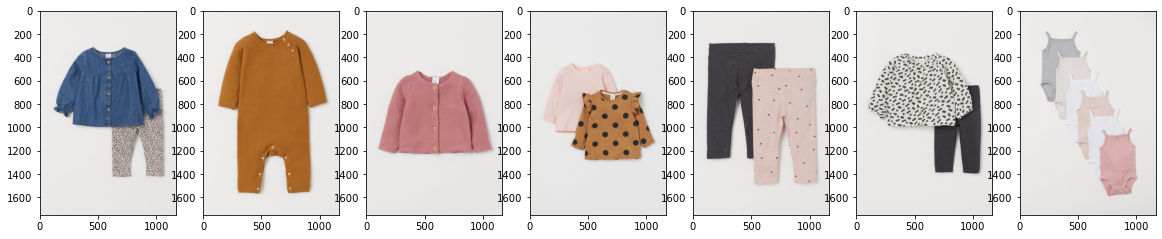

In [42]:
plot_purchase_history()

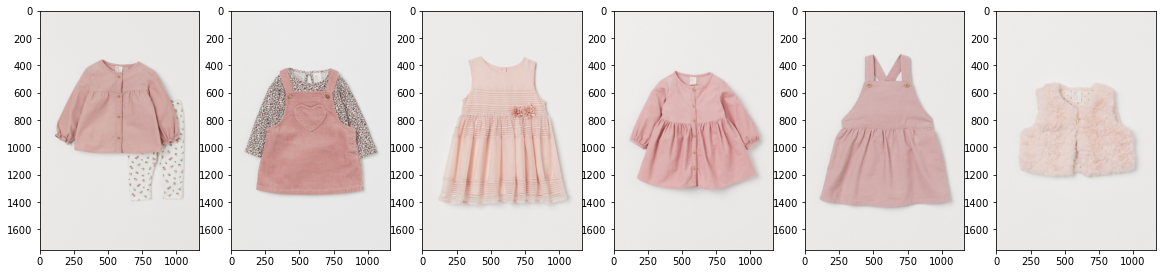

In [43]:
plot_recommendation()